In [1]:
import numpy as np
from src.Preprocessing import create_labels_single_column
from src.Particle import ParticleType
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_predict

In [2]:
# loading the data
efps_top = np.load("../../../Data/t_efps_d5_primed.npy")
efps_gluon = np.load("../../../Data/g_efps_d5_primed.npy")
efps_quark = np.load("../../../Data/q_efps_d5_primed.npy")

print(f"Number of Top Jets: {efps_top.shape[0]}")
print(f"Number of Gluon Jets: {efps_gluon.shape[0]}")
print(f"Number of LightQuark Jets: {efps_quark.shape[0]}")

Number of Top Jets: 177945
Number of Gluon Jets: 177252
Number of LightQuark Jets: 170679


In [3]:
# joinning the data 
# half of the data represents Top jets, the other half represents non-top quark jets
X = np.vstack((efps_top, efps_gluon[: int(efps_gluon.shape[0]/2)], efps_quark[: int(efps_quark.shape[0]/2)]))
y = create_labels_single_column(jet_inputs={ParticleType.Gluon: (efps_top.shape[0], X.shape[0] - 1), ParticleType.Top: (0, efps_top.shape[0] - 1)})
# shuffling the data
X, y = shuffle(X, y, random_state=42)

In [4]:
# Let us use the StandardScaler to leave each feature with the same order of magniture
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
# Dividing the data into trainning, validation, and test
# diving the set into trainning, validation, and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

print(f"Size of the Training set: {X_train.shape[0]}")
print(f"Size of the Validation set: {X_val.shape[0]}")
print(f"Size of the Test set: {X_test.shape[0]}")

Size of the Training set: 254254
Size of the Validation set: 44869
Size of the Test set: 52787


In [24]:
# defining the model
# d <= 5
# l2, C = 0.04, solver = lbfgs
# l1, C = 0.001, solver = saga
# d <= 7
# l2, C = 0.01, solver = lbfgs
log_reg = LogisticRegression(penalty='l1', C=0.001, solver='saga', max_iter=500)
log_reg.fit(X_train, y_train)

coefs = ', '.join([f'{val:.2f}' for val in log_reg.coef_[0]])
print(f"Coefficients:", coefs)
print(f"Intercept {log_reg.intercept_[0]:.3f}")

Coefficients: 3.48, 0.00, 0.00, -0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.92, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, -1.89, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.11, 0.00, 0.00, 0.00, 0.00, 0.02, 0.00, 0.00, 0.00, 0.00, 0.00
Intercept 0.034


In [25]:
print("Non-vanishing coefficients indices:")
best_efps = np.where(abs(log_reg.coef_[0]) > 0)[0]
print(best_efps)

Non-vanishing coefficients indices:
[ 0  3 14 31 42 47]


In [23]:
# Tranning set
y_train_predict = log_reg.predict(X_train)

print("Trainnig set:")
print(f"Recall for Top tagging: {recall_score(y_train, y_train_predict):.2f}")
print(f"Precision for Top tagging: {precision_score(y_train, y_train_predict):.2f}")
print("Confusion Matrix")
print(confusion_matrix(y_train, y_train_predict, labels=[0, 1]))

Trainnig set:
Recall for Top tagging: 0.89
Precision for Top tagging: 0.87
Confusion Matrix
[[108217  17316]
 [ 14213 114508]]


In [19]:
y_val_predict = log_reg.predict(X_val)

print("Validation set:")
print(f"Recall for Top tagging: {recall_score(y_val, y_val_predict):.2f}")
print(f"Precision for Top tagging: {precision_score(y_val, y_val_predict):.2f}")
print("Confusion Matrix")
print(confusion_matrix(y_val, y_val_predict, labels=[0, 1]))

Validation set:
Recall for Top tagging: 0.89
Precision for Top tagging: 0.87
Confusion Matrix
[[19242  3012]
 [ 2436 20179]]


In [20]:
# Test set
y_test_predict = log_reg.predict(X_test)

print("Test set:")
print(f"Recall for Top tagging: {recall_score(y_test, y_test_predict):.2f}")
print(f"Precision for Top tagging: {precision_score(y_test, y_test_predict):.2f}")
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_predict, labels=[0, 1]))

Test set:
Recall for Top tagging: 0.89
Precision for Top tagging: 0.87
Confusion Matrix
[[22611  3567]
 [ 2846 23763]]


In [13]:
# evaluating the probabilities of each sample in the trainning data using 
# K-fold cross validation - it returns the probability of the sample in each class
y_probabilities = cross_val_predict(log_reg, X_train, y_train, cv=6, method='predict_proba')

[]

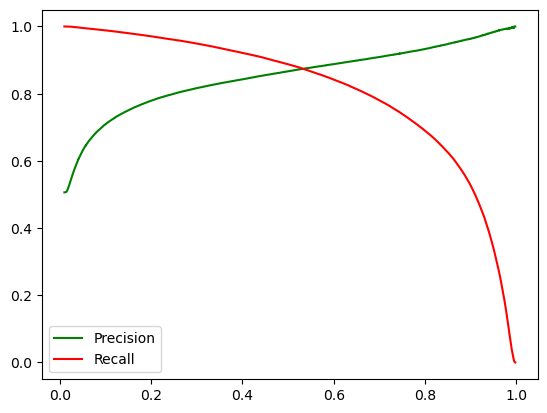

In [14]:
y_score = y_probabilities[:, 1]
precision, recall, thresholds = precision_recall_curve(y_train, y_score)
plt.plot(thresholds, precision[:-1], label='Precision', color='green')
plt.plot(thresholds, recall[:-1], label='Recall', color='red')
plt.legend(loc='best')
plt.plot()

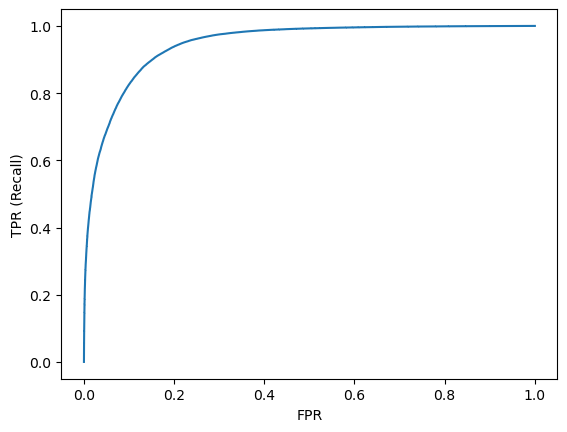

AUC: 0.95


In [15]:
# roc curve for top tagging 
fpr, tpr, thresholds = roc_curve(y_train, y_score)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.show()
print(f"AUC: {auc(fpr, tpr):.2f}")